### IMPORT ALL LIBRARY

In [6]:
import sys
# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [7]:
import numpy as np
import pandas as pd
from numpy import argmax
import random
import tensorflow as tf
import datetime,os
import tensorflow_datasets as tfds
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential, layers, datasets
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout, Conv2D,MaxPool2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# PART 1 (CREATING INPUT PIPELINES)

In [8]:
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True,batch_size=-1)

train_images, train_labels   = tfds.as_numpy(train_ds)
test_images, test_labels   = tfds.as_numpy(test_ds)
train_images, test_images = train_images / 255.0, test_images / 255.0

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteACQCM6/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteACQCM6/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [9]:
train_images.shape

(50000, 32, 32, 3)

In [10]:
# DATA AUGMENTATION 
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [11]:
# All the classes of the images to predict
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

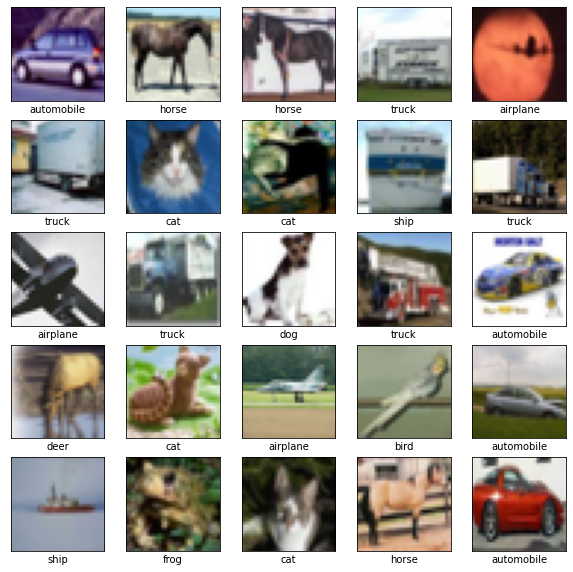

In [12]:
# Plotting the training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    p = random.randint(0,train_images.shape[0])
    plt.imshow(train_images[p])
    plt.xlabel(class_names[train_labels[p]])
plt.show()

In [13]:
# plot learning curves
def summarize_results(histories):
    # plot loss
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()

    # plot accuracy
    plt.subplot(212)
    plt.ylabel('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()

    plt.show()
 

### MODEL

In [14]:
def create_model():
    
    model = Sequential()
    model.add(InputLayer(input_shape=(32, 32, 3)))
    
    # block 1
    model.add(Conv2D(64, (3,3),activation='relu',padding='same',kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3,3),activation='relu',padding='same',kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.1))

    # block 2
    model.add(Conv2D(128, (3,3),activation='relu',padding='same',kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3),activation='relu',padding='same',kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))

    # block 3
    model.add(Conv2D(256, (3,3),activation='relu',padding='same',kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(256, (3,3),activation='relu',padding='same',kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.3))


    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))

    return model

In [15]:
model = create_model()
optimizer = tf.optimizers.SGD(learning_rate=0.1)
# Comiple the mode with the optimizer and learning rate 
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

In [17]:
def model_checkpoint(path):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback
filepath = './cifar10_model/model_checkpoint'

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
history = model.fit(datagen.flow(train_images, train_labels,batch_size=64),
                    epochs=50,callbacks=[reduce_lr,model_checkpoint(filepath)],validation_data = (test_images, test_labels))

Epoch 1/50
782/782 [==============================] - 54s 67ms/step - loss: 1.8249 - accuracy: 0.3568 - val_loss: 2.0357 - val_accuracy: 0.3639
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 2/50
782/782 [==============================] - 52s 67ms/step - loss: 1.5066 - accuracy: 0.4810 - val_loss: 1.5282 - val_accuracy: 0.4830
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 3/50
782/782 [==============================] - 52s 66ms/step - loss: 1.3584 - accuracy: 0.5439 - val_loss: 1.8248 - val_accuracy: 0.4777
Epoch 4/50
782/782 [==============================] - 52s 67ms/step - loss: 1.2586 - accuracy: 0.5802 - val_loss: 1.2650 - val_accuracy: 0.6136
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 5/50
782/782 [==============================] - 52s 66ms/step - loss: 1.1839 - accuracy: 0.6158 - val_loss: 1.2434 - val_accuracy: 0.6096
Epoch 6/50
782/782 [==============================] - 52s 67ms/step - loss: 1.1209 - accuracy: 0.6424 - val_loss: 1.0422 - val_accuracy: 0.6877
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 7/50
782/782 [==============================] - 52s 67ms/step - loss: 1.0705 - accuracy: 0.6606 - val_loss: 1.0536 - val_accuracy: 0.6841
Epoch 8/50
782/782 [==============================] - 51s 65ms/step - loss: 1.0242 - accuracy: 0.6784 - val_loss: 1.0806 - val_accuracy: 0.6838
Epoch 9/50
782/782 [==============================] - 51s 65ms/step - loss: 0.9886 - accuracy: 0.6928 - val_loss: 1.0713 - val_accuracy: 0.7024
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 10/50
782/782 [==============================] - 52s 67ms/step - loss: 0.9642 - accuracy: 0.7031 - val_loss: 0.8209 - val_accuracy: 0.7591
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 11/50
782/782 [==============================] - 52s 67ms/step - loss: 0.9408 - accuracy: 0.7105 - val_loss: 0.9238 - val_accuracy: 0.7319
Epoch 12/50
782/782 [==============================] - 51s 66ms/step - loss: 0.9239 - accuracy: 0.7178 - val_loss: 0.8603 - val_accuracy: 0.7475
Epoch 13/50
782/782 [==============================] - 51s 65ms/step - loss: 0.9043 - accuracy: 0.7267 - val_loss: 0.7477 - val_accuracy: 0.7878
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 14/50
782/782 [==============================] - 51s 65ms/step - loss: 0.8758 - accuracy: 0.7384 - val_loss: 0.9563 - val_accuracy: 0.7373
Epoch 15/50
782/782 [==============================] - 51s 65ms/step - loss: 0.8594 - accuracy: 0.7421 - val_loss: 0.7377 - val_accuracy: 0.7928
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 16/50
782/782 [==============================] - 51s 65ms/step - loss: 0.8482 - accuracy: 0.7512 - val_loss: 0.9784 - val_accuracy: 0.7327
Epoch 17/50
782/782 [==============================] - 51s 65ms/step - loss: 0.8364 - accuracy: 0.7537 - val_loss: 0.7091 - val_accuracy: 0.8014
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 18/50
782/782 [==============================] - 51s 65ms/step - loss: 0.8177 - accuracy: 0.7632 - val_loss: 0.7719 - val_accuracy: 0.7914
Epoch 19/50
782/782 [==============================] - 51s 65ms/step - loss: 0.8175 - accuracy: 0.7639 - val_loss: 0.9251 - val_accuracy: 0.7500
Epoch 20/50
782/782 [==============================] - 51s 65ms/step - loss: 0.7985 - accuracy: 0.7701 - val_loss: 0.8688 - val_accuracy: 0.7638
Epoch 21/50
782/782 [==============================] - 51s 65ms/step - loss: 0.7944 - accuracy: 0.7693 - val_loss: 0.8189 - val_accuracy: 0.7742
Epoch 22/50
782/782 [==============================] - 51s 66ms/step - loss: 0.7358 - accuracy: 0.7919 - val_loss: 0.6343 - val_accuracy: 0.8260
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 23/50
782/782 [==============================] - 52s 66ms/step - loss: 0.7206 - accuracy: 0.7975 - val_loss: 0.7346 - val_accuracy: 0.8083
Epoch 24/50
782/782 [==============================] - 51s 66ms/step - loss: 0.7138 - accuracy: 0.7995 - val_loss: 0.6222 - val_accuracy: 0.8357
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 25/50
782/782 [==============================] - 53s 67ms/step - loss: 0.7042 - accuracy: 0.8025 - val_loss: 0.6696 - val_accuracy: 0.8243
Epoch 26/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6909 - accuracy: 0.8057 - val_loss: 0.6415 - val_accuracy: 0.8317
Epoch 27/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6901 - accuracy: 0.8064 - val_loss: 0.6805 - val_accuracy: 0.8160
Epoch 28/50
782/782 [==============================] - 52s 67ms/step - loss: 0.6845 - accuracy: 0.8110 - val_loss: 0.6232 - val_accuracy: 0.8358
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 29/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6515 - accuracy: 0.8203 - val_loss: 0.6168 - val_accuracy: 0.8381
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 30/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6448 - accuracy: 0.8209 - val_loss: 0.5838 - val_accuracy: 0.8463
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 31/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6397 - accuracy: 0.8230 - val_loss: 0.5960 - val_accuracy: 0.8445
Epoch 32/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6356 - accuracy: 0.8247 - val_loss: 0.5918 - val_accuracy: 0.8456
Epoch 33/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6317 - accuracy: 0.8269 - val_loss: 0.6262 - val_accuracy: 0.8364
Epoch 34/50
782/782 [==============================] - 52s 67ms/step - loss: 0.6229 - accuracy: 0.8281 - val_loss: 0.5705 - val_accuracy: 0.8511
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 35/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6224 - accuracy: 0.8276 - val_loss: 0.5699 - val_accuracy: 0.8487
Epoch 36/50
782/782 [==============================] - 52s 67ms/step - loss: 0.6193 - accuracy: 0.8290 - val_loss: 0.5719 - val_accuracy: 0.8511
Epoch 37/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6219 - accuracy: 0.8298 - val_loss: 0.5683 - val_accuracy: 0.8538
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 38/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6096 - accuracy: 0.8321 - val_loss: 0.5986 - val_accuracy: 0.8441
Epoch 39/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6057 - accuracy: 0.8340 - val_loss: 0.5738 - val_accuracy: 0.8530
Epoch 40/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6148 - accuracy: 0.8307 - val_loss: 0.5771 - val_accuracy: 0.8498
Epoch 41/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6025 - accuracy: 0.8348 - val_loss: 0.5485 - val_accuracy: 0.8589
INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 42/50
782/782 [==============================] - 52s 66ms/step - loss: 0.6058 - accuracy: 0.8322 - val_loss: 0.6214 - val_accuracy: 0.8385
Epoch 43/50
782/782 [==============================] - 52s 67ms/step - loss: 0.6016 - accuracy: 0.8344 - val_loss: 0.5534 - val_accuracy: 0.8571
Epoch 44/50
782/782 [==============================] - 52s 66ms/step - loss: 0.5919 - accuracy: 0.8375 - val_loss: 0.6080 - val_accuracy: 0.8420
Epoch 45/50
782/782 [==============================] - 52s 66ms/step - loss: 0.5925 - accuracy: 0.8379 - val_loss: 0.5793 - val_accuracy: 0.8493
Epoch 46/50
782/782 [==============================] - 52s 66ms/step - loss: 0.5804 - accuracy: 0.8408 - val_loss: 0.5483 - val_accuracy: 0.8568
Epoch 47/50
782/782 [==============================] - 52s 66ms/step - loss: 0.5756 - accuracy: 0.8425 - val_loss: 0.5511 - val_accuracy: 0.8571
Epoch 48/50
782/782 [==============================] - 52s 66ms/step - loss: 0.5689 - accuracy: 0.8432 - val_loss: 0.5915 - val_ac

INFO:tensorflow:Assets written to: ./cifar10_model/model_checkpoint/assets


Epoch 50/50
782/782 [==============================] - 52s 66ms/step - loss: 0.5665 - accuracy: 0.8451 - val_loss: 0.5409 - val_accuracy: 0.8576


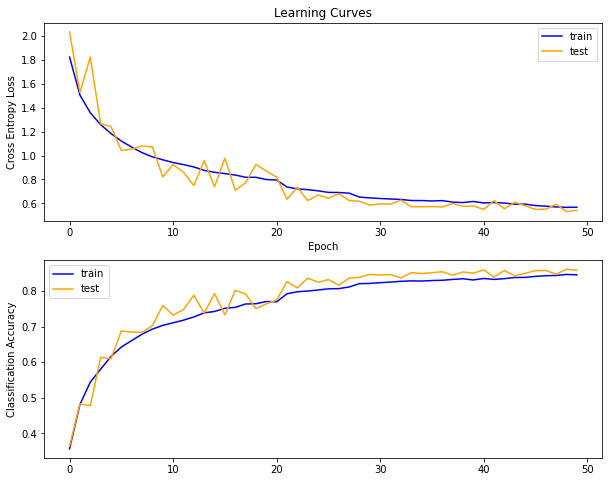

In [22]:
summarize_results(history)

In [21]:
!unzip "/content/model.zip" -d "/content/model/"

Archive:  /content/model.zip
   creating: /content/model/assets/
   creating: /content/model/variables/
  inflating: /content/model/keras_metadata.pb  
  inflating: /content/model/saved_model.pb  
  inflating: /content/model/variables/variables.index  
  inflating: /content/model/variables/variables.data-00000-of-00001  


In [23]:
# Loading the best model
model = tf.keras.models.load_model('/content/model')

In [24]:
# evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=3)
print('Test Accuracy: %.4f' % acc)

Test Accuracy: 0.8611


In [25]:
predictions = np.argmax(model.predict(test_images, verbose=0),axis=1)

In [26]:
print(confusion_matrix(test_labels, predictions))

[[873  16  15   5   4   0   6   8  55  18]
 [  5 950   0   0   0   0   1   1  12  31]
 [ 44   2 806  20  30  12  68   9   3   6]
 [ 15  13  32 718  31  63  77  15  21  15]
 [  8   0  32  29 820   7  70  25   6   3]
 [  3   7  23 108  27 756  40  17   6  13]
 [  3   4  10   7  10   3 954   1   4   4]
 [ 13   1  17  15  40  13  12 881   0   8]
 [ 25   9   3   0   0   0   2   0 942  19]
 [ 16  42   1   3   1   0  10   1  15 911]]


In [27]:
print(classification_report(test_labels, predictions,target_names = class_names))

              precision    recall  f1-score   support

    airplane       0.87      0.87      0.87      1000
  automobile       0.91      0.95      0.93      1000
        bird       0.86      0.81      0.83      1000
         cat       0.79      0.72      0.75      1000
        deer       0.85      0.82      0.84      1000
         dog       0.89      0.76      0.82      1000
        frog       0.77      0.95      0.85      1000
       horse       0.92      0.88      0.90      1000
        ship       0.89      0.94      0.91      1000
       truck       0.89      0.91      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [28]:
# import shutil
# shutil.make_archive('model', 'zip', filepath)

### TF SERVING WITH REST API

In [29]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = '/content/serving_model'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /content/serving_model/1

INFO:tensorflow:Assets written to: /content/serving_model/1/assets


INFO:tensorflow:Assets written to: /content/serving_model/1/assets



Saved model:
total 664
drwxr-xr-x 2 root root   4096 Oct  8 07:51 assets
-rw-r--r-- 1 root root  47634 Oct  8 07:51 keras_metadata.pb
-rw-r--r-- 1 root root 621408 Oct  8 07:51 saved_model.pb
drwxr-xr-x 2 root root   4096 Oct  8 07:51 variables


In [31]:
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio
import subprocess

Installing dependencies for Colab environment
TensorFlow version: 2.6.0


In [32]:
!saved_model_cli show --dir {export_path} --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 32, 3)
        name: serving_default_input_3:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/l

In [33]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [34]:

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  17517      0 --:--:-- --:--:-- --:--:-- 17517
OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://deve

In [35]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 347 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.6.0 [347 MB]
Fetched 347 MB in 5s (68.6 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.6.0_all.deb ...
Unpacking tensorflow-model-server (2.6.0) ...
Setting up tensorflow-model-server (2.6.0) ...


In [36]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [46]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=cifar10_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 0 in a separate thread.


In [47]:
!tail server.log

2021-10-08 08:09:16.983168: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 183618 microseconds.
2021-10-08 08:09:16.987811: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /content/serving_model/1/assets.extra/tf_serving_warmup_requests
2021-10-08 08:09:16.988018: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cifar10_model version: 1}
2021-10-08 08:09:16.989185: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-10-08 08:09:16.989264: I tensorflow_serving/model_servers/server.cc:133] Using InsecureServerCredentials
2021-10-08 08:09:16.989279: I tensorflow_serving/model_servers/server.cc:383] Profiler service is enabled
2021-10-08 08:09:16.989787: I tensorflow_serving/model_servers/server.cc:409] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address

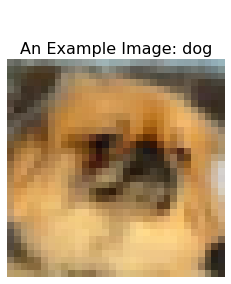

In [48]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(32,32,3))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

### TEST THE API

In [49]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 6666667, 0.6196078431372549, 0.4823529411764706]]]]}


In [50]:
!pip install -q requests

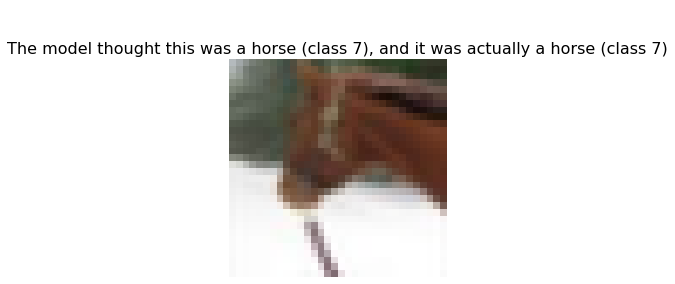

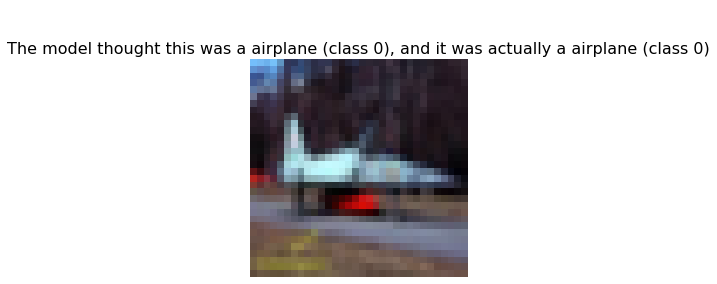

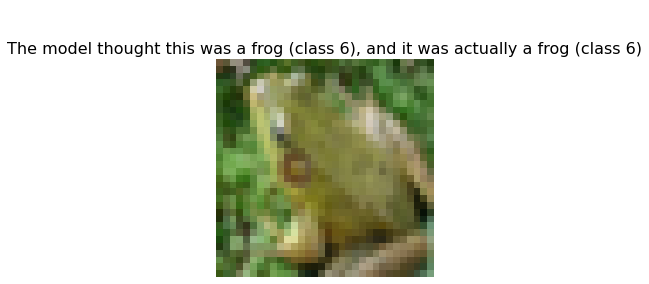

In [54]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/cifar10_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))

In [55]:
import shutil
shutil.make_archive('tfx_server', 'zip', export_path)

'/content/tfx_server.zip'